In [50]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from prep_data import prep_data
import numpy as np
import itertools

In [3]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

In [4]:
train_loader, test_loader = prep_data()

(2, 5)


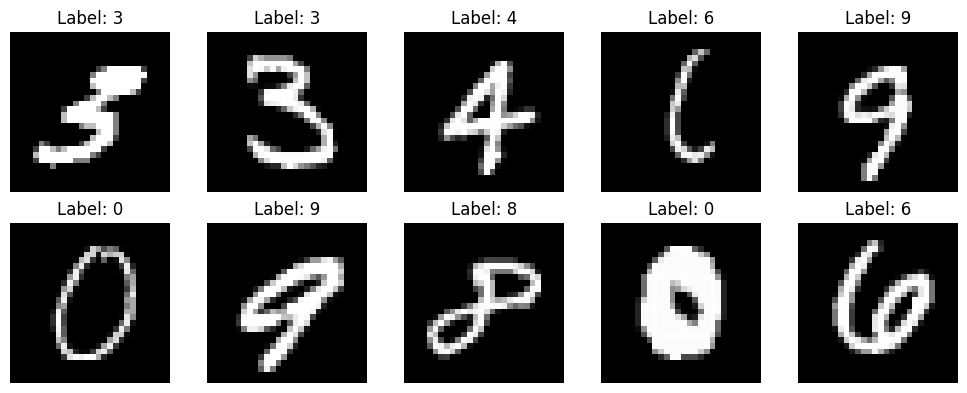

In [5]:
# Function to display images
def show_images(images, labels):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    axs = axes.flatten()
    print(axes.shape)
    for i in range(10):
        axs[i].imshow(images[i].reshape(28, 28), cmap='gray')
        axs[i].set_title(f"Label: {labels[i]}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, lbls = next(dataiter)

# Show images
show_images(images[:10], lbls[:10])

In [6]:
class ShallowNN(nn.Module):
    def __init__(self, latent_size=128):
        super().__init__()
        self.dim_reduction = nn.Linear(28*28, latent_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(128, 10)

    def forward(self, x):
        x = self.dim_reduction(x)
        x = self.relu(x)
        return self.output(x)

class MultiLayerNN(nn.Module):
    def __init__(self, latent_size=128, num_layers=3):
        super().__init__()
        self.dim_reduction = nn.Linear(28*28, latent_size)
        layers = []
        for i in range(num_layers):
            layers.extend([nn.Linear(latent_size, latent_size), nn.ReLU()])
        self.hidden_layers = nn.ModuleList(
            layers,
        )
        self.output = nn.Linear(latent_size, 10)

    def forward(self, x):
        x = self.dim_reduction(x)
        x = nn.ReLU()(x)
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output(x)

In [7]:
model = torch.compile(MultiLayerNN(latent_size=128, num_layers=3), mode="max-autotune").to(device)

In [8]:
optim = torch.optim.AdamW(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=30)
criterion = torch.nn.CrossEntropyLoss()

In [9]:
for epoch in range(30):
    for data, labels in train_loader:
        data = data.view(-1, 28*28).to(device)
        labels = labels.to(device)
        preds = model(data)
        loss = criterion(preds, labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
    scheduler.step()
    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

Epoch 1 | Loss: 0.3039
Epoch 2 | Loss: 0.1557
Epoch 3 | Loss: 0.1144
Epoch 4 | Loss: 0.0591
Epoch 5 | Loss: 0.2014
Epoch 6 | Loss: 0.1832
Epoch 7 | Loss: 0.1040
Epoch 8 | Loss: 0.1216
Epoch 9 | Loss: 0.1172
Epoch 10 | Loss: 0.1626
Epoch 11 | Loss: 0.2954
Epoch 12 | Loss: 0.1219
Epoch 13 | Loss: 0.0457
Epoch 14 | Loss: 0.1470
Epoch 15 | Loss: 0.0301
Epoch 16 | Loss: 0.1063
Epoch 17 | Loss: 0.0172
Epoch 18 | Loss: 0.0007
Epoch 19 | Loss: 0.0034
Epoch 20 | Loss: 0.0026
Epoch 21 | Loss: 0.0131
Epoch 22 | Loss: 0.0004
Epoch 23 | Loss: 0.0000
Epoch 24 | Loss: 0.0000
Epoch 25 | Loss: 0.0001
Epoch 26 | Loss: 0.0000
Epoch 27 | Loss: 0.0001
Epoch 28 | Loss: 0.0000
Epoch 29 | Loss: 0.0000
Epoch 30 | Loss: 0.0000


Accuracy: 0.9820


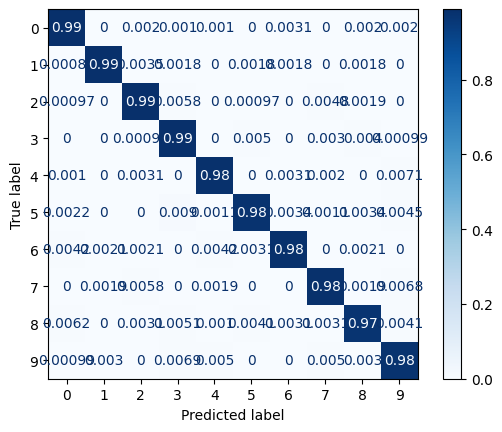

In [10]:
cm = torch.zeros(10, 10)
with torch.no_grad():
    for data, labels in test_loader:
        data = data.view(-1, 28*28).to(device)
        labels = labels.to(device)
        preds = model(data)
        for i, pred in enumerate(preds):
            cm[labels[i], pred.argmax()] += 1
cm = cm.cpu().numpy()
accuracy = cm.diagonal().sum() / cm.sum()
cm = cm / cm.sum(axis=1, keepdims=True)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
print(f"Accuracy: {accuracy:.4f}")

In [11]:
full_mnist = []
labels = []
for data, lbls in train_loader:
    full_mnist.append(data.view(-1, 28*28))
    labels.append(lbls)
for data, lbls in test_loader:
    full_mnist.append(data.view(-1, 28*28))
    labels.append(lbls)
full_mnist = torch.cat(full_mnist)
labels = torch.cat(labels)
full_mnist.shape, (full_mnist.numel() * full_mnist.element_size()) / 1e6

(torch.Size([70000, 784]), 219.52)

In [12]:
full_mnist.min(dim=1)

torch.return_types.min(
values=tensor([0., 0., 0.,  ..., 0., 0., 0.]),
indices=tensor([0, 0, 0,  ..., 0, 0, 0]))

In [13]:
def plot_points(points, ax, labels=labels):
    points = points.detach().cpu()
    _, _, principal_components = torch.pca_lowrank(points, q=min(10, points.shape[-1]), niter=5)
    projected_points = torch.matmul(points, principal_components[:, :2]).numpy()
    projected_points = (projected_points - projected_points.mean(axis=0, keepdims=True)) / projected_points.std(axis=0, keepdims=True)
    colors = plt.get_cmap('tab10', 10)
    for label in range(10):
        label_mask = labels == label
        ax.scatter(projected_points[label_mask, 0], projected_points[label_mask, 1], color=colors(label), s=1, alpha=0.3, label=label)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.legend()
    return ax

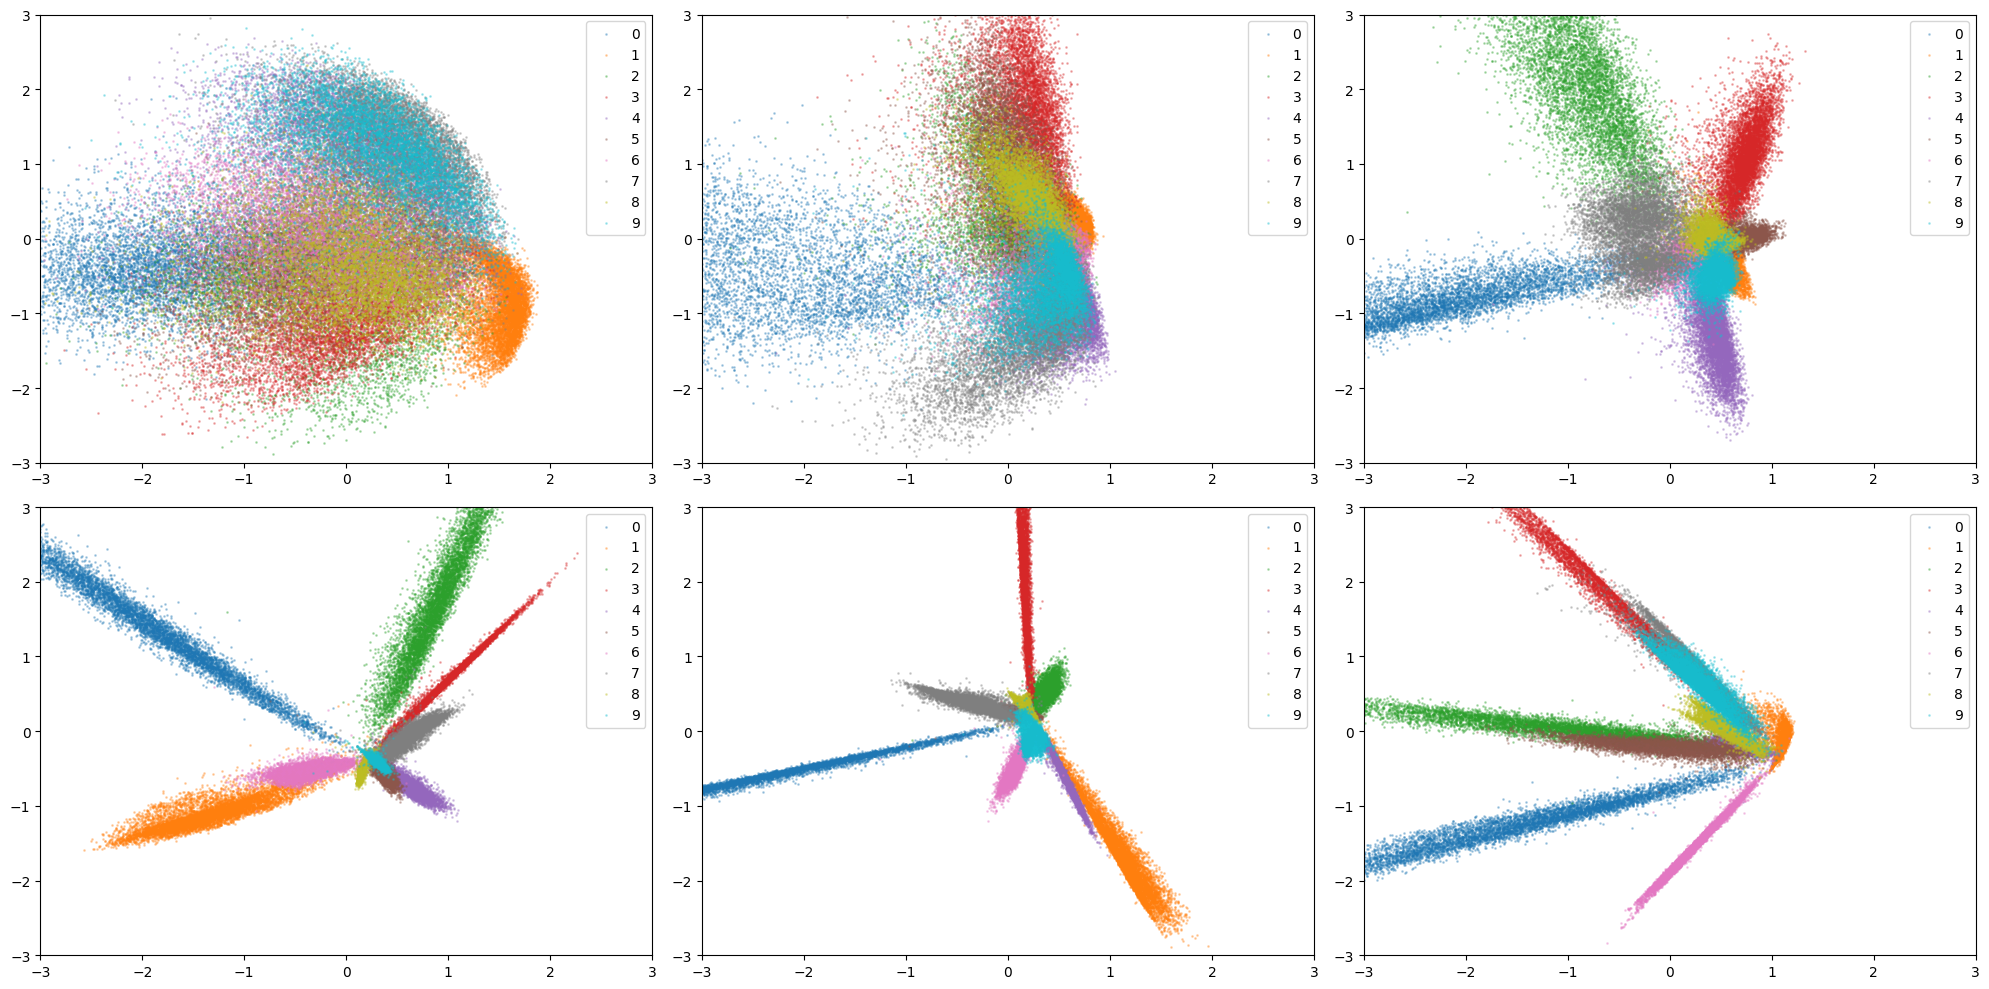

In [14]:
layers = [lambda x: x, model.dim_reduction, *[model.hidden_layers[i] for i in range(0, len(model.hidden_layers), 2)], model.output]
fig, axs = plt.subplots(2, len(layers)//2, figsize=(20, 10))
axs = axs.flatten()
pipeline_points = full_mnist.to(device)
for i, layer in enumerate(layers):
    pipeline_points = layer(pipeline_points)
    if i != 0 and i != len(layers)-1:
        pipeline_points = nn.ReLU()(pipeline_points)
    ax = plot_points(pipeline_points, axs[i])
    #ax.axis('off')
plt.tight_layout()
plt.show()

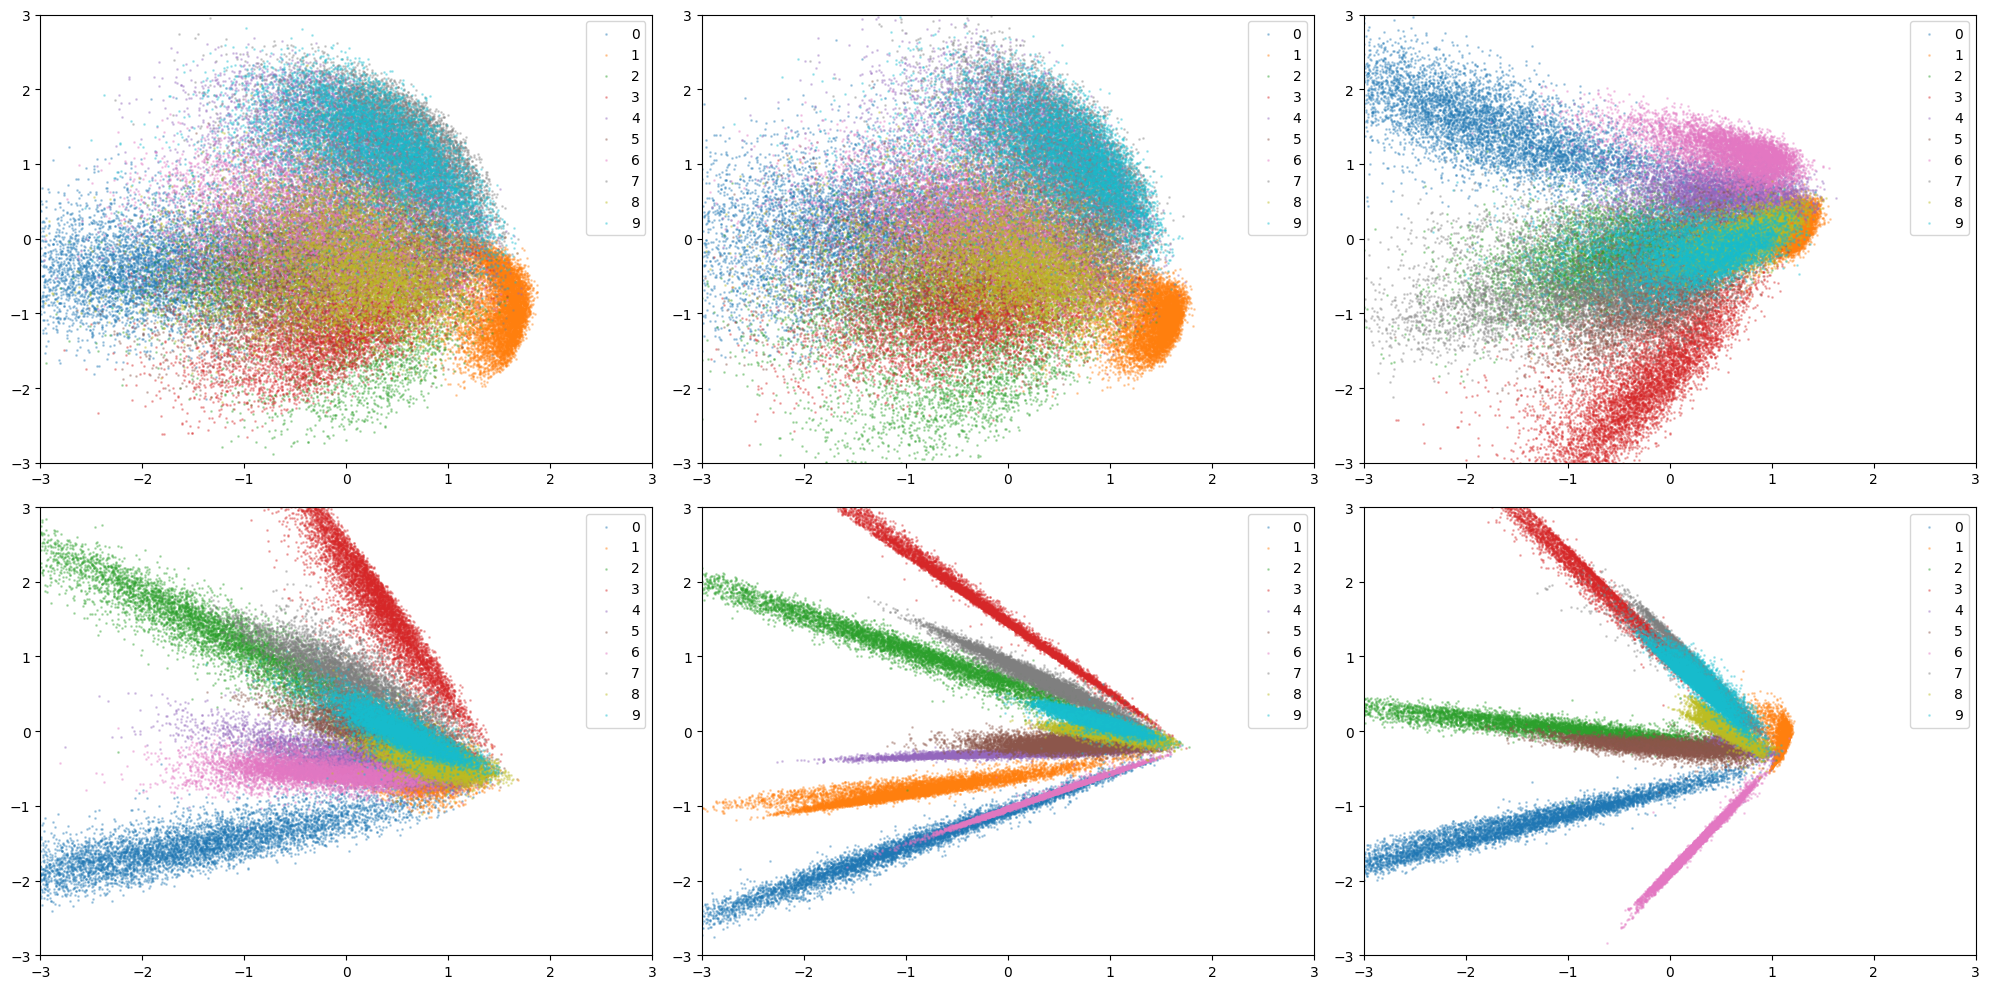

In [15]:
layers = [lambda x: x, model.dim_reduction, *[model.hidden_layers[i] for i in range(0, len(model.hidden_layers), 2)], model.output]
fig, axs = plt.subplots(2, len(layers)//2, figsize=(20, 10))
axs = axs.flatten()
pipeline_points = full_mnist.to(device)
for i, layer in enumerate(layers):
    pipeline_points = layer(pipeline_points)
    ax = plot_points(pipeline_points, axs[i])
    if i != 0 and i != len(layers)-1:
        pipeline_points = nn.ReLU()(pipeline_points)
    #ax.axis('off')
plt.tight_layout()
plt.show()

/Users/josecruz/anaconda3/lib/python3.10/site-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


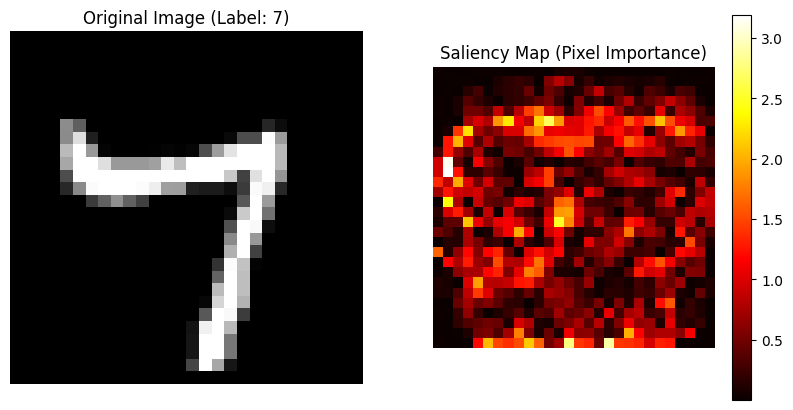

In [16]:
from captum.attr import Saliency

idx = np.random.randint(0, len(full_mnist))
# Get a single image and label from the test set
image, label = full_mnist[idx], labels[idx]

# --- Saliency Map Calculation ---
saliency = Saliency(model)
# Calculate gradients of the output with respect to the input
# The target is the correct class label for this image
grads = saliency.attribute(image.unsqueeze(0).to(device), target=label.item())

# The absolute values of the gradients indicate feature importance
# Reshape the gradients back to a 28x28 image
saliency_map = grads.detach().cpu().numpy().reshape(28, 28)

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original Image
axes[0].imshow(image.numpy().reshape(28, 28), cmap='gray')
axes[0].set_title(f'Original Image (Label: {label.item()})')
axes[0].axis('off')

# Saliency Map
im = axes[1].imshow(saliency_map, cmap='hot')
axes[1].set_title('Saliency Map (Pixel Importance)')
axes[1].axis('off')
fig.colorbar(im, ax=axes[1])

plt.show()

In [17]:
# --- Feature Visualization Setup ---
target_class = 6  # The digit we want to visualize
# Start with a random image (noise) and make it optimizable
# Start with a random tensor (doesn't need grad yet)
initial_noise = torch.randn(10, 28 * 28)

# Create the tensor to be optimized. This pattern ensures it's a leaf.
# .clone() makes a copy.
# .detach() severs it from any computation history.
# .requires_grad_(True) marks it as a leaf tensor we want to optimize.
dream_image = initial_noise.clone().to(device).detach().requires_grad_(True)

optimizer = (torch.optim.Adam([dream_image], lr=0.001))

# --- Optimization Loop ---
for i in range(500): # Run for 200 steps
    optimizer.zero_grad()
    # Forward pass the image through the model
    output = model(dream_image)
    # We want to MAXIMIZE the logit for our target class,
    # so we use its negative as our loss to MINIMIZE.
    loss = -output.diag().mean()
    loss.backward()
    optimizer.step()

# --- Visualization ---
# Get the final optimized image
final_images = dream_image.detach().cpu().numpy().reshape(-1, 28, 28)

In [18]:
lbl_masks = labels[:, None] == torch.arange(10)
class_counts = lbl_masks.sum(dim=0)
avg_images = torch.zeros(10, 28*28)
avg_images.scatter_add_(0, labels.unsqueeze(1).expand(-1, 28*28), full_mnist)
avg_images /= class_counts[:, None]
avg_images = avg_images.reshape(10, 28, 28).detach().cpu().numpy()

In [19]:
activations = avg_images[None, ...] * final_images[:, None]

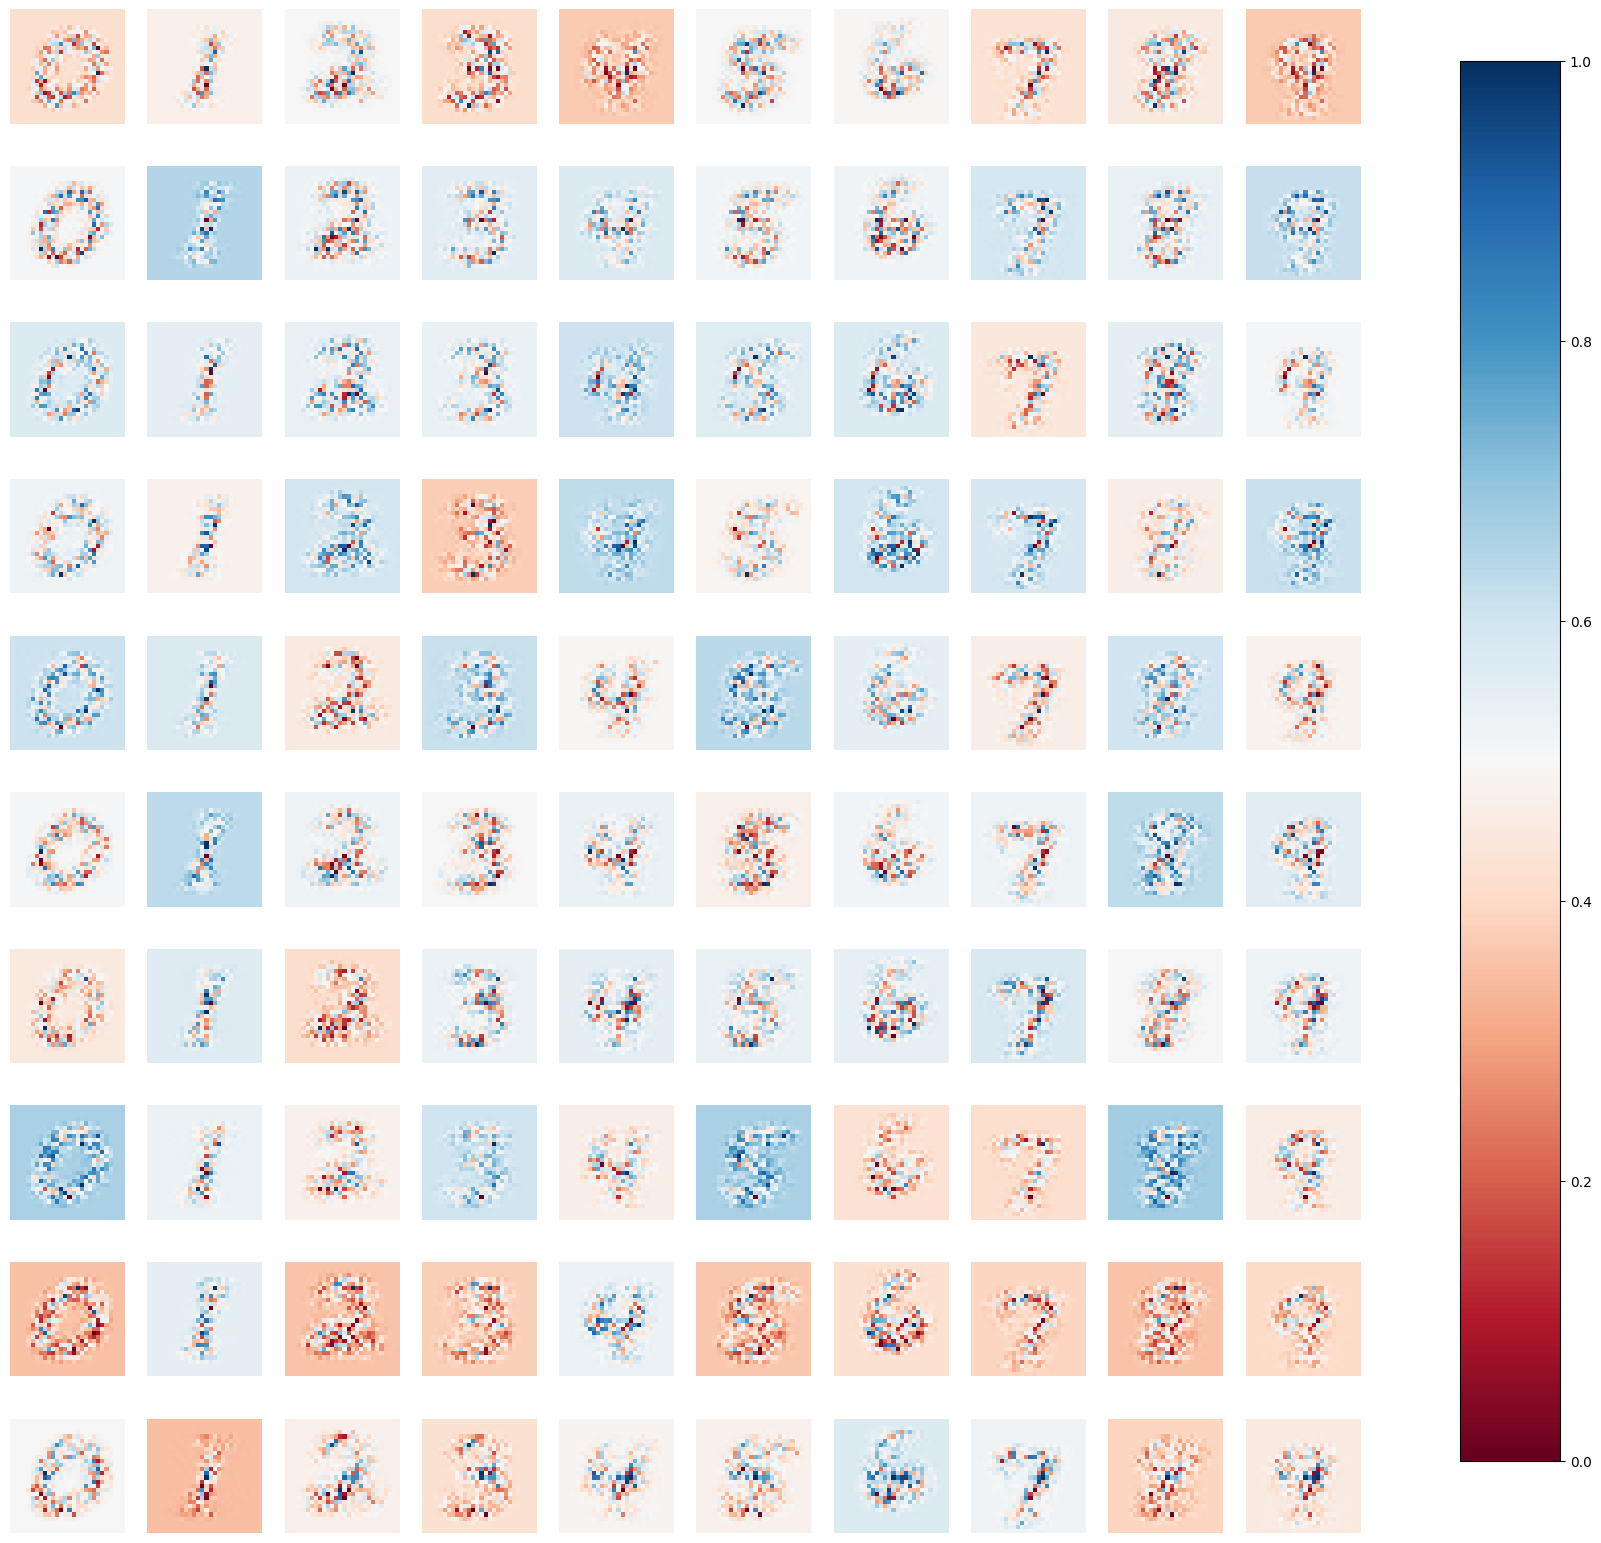

In [20]:
fig, axs = plt.subplots(10, 10, figsize=(20, 20))
normalize = lambda x: (x - x.min()) / (x.max() - x.min())
for i in range(10):
    for j in range(10):
        im = axs[i, j].imshow(normalize(activations[i, j]), cmap='RdBu')
        axs[i, j].axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)


In [36]:
def get_mean_activation_map(model, target_layer, target_class, dataset):
    """
    Calculates the average activation of a target layer for a specific class.

    Args:
        model (nn.Module): The trained neural network.
        target_layer (nn.Module): The specific layer within the model to inspect (e.g., model.layers[0]).
        target_class (int): The class index (0-9 for MNIST) to visualize.
        dataset (Dataset): The dataset to draw samples from.
    """
    model.eval()
    activations = []

    # --- Step 1: Attach a forward hook to the target layer ---
    # A hook is a function that runs during the forward or backward pass.
    # This hook will save the layer's output (activations) to our list.
    def hook_fn(module, input, output):
        activations.append(output.detach())

    hook = target_layer.register_forward_hook(hook_fn)

    # --- Step 2: Pass all images of the target class through the model ---
    with torch.no_grad():
        for img, label in dataset:
            if label == target_class:
                # We only need to run the forward pass; the hook will capture the activations.
                model(img.unsqueeze(0)) # Add batch dimension

    # --- Step 3: Clean up the hook and calculate the mean ---
    hook.remove() # It's important to remove hooks when you're done!

    if not activations:
        print(f"No samples found for class {target_class}.")
        return None

    # Stack all captured activations into a single tensor and compute the mean
    all_activations = torch.cat(activations)
    mean_activation = all_activations.mean(dim=0)

    return mean_activation.cpu().numpy()

(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)


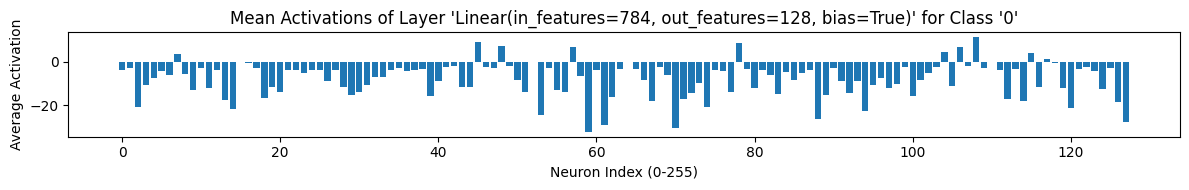

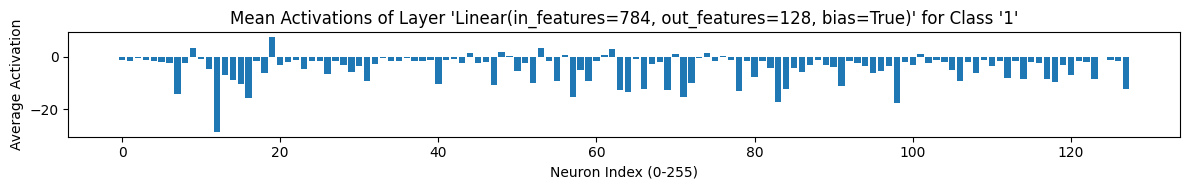

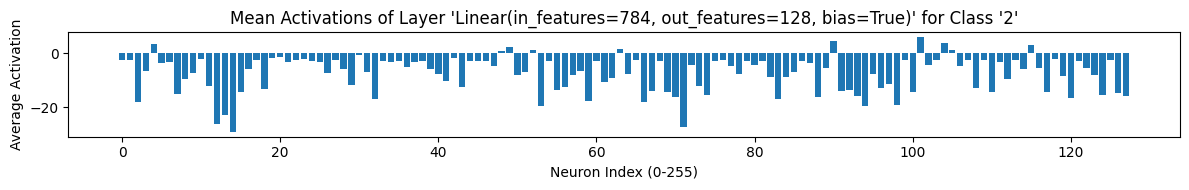

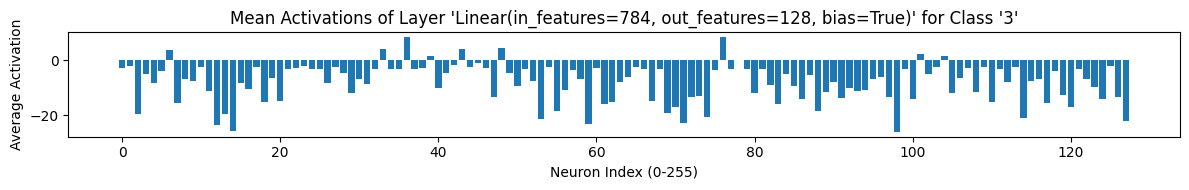

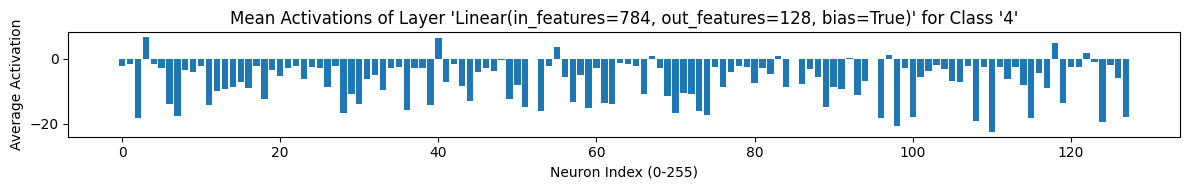

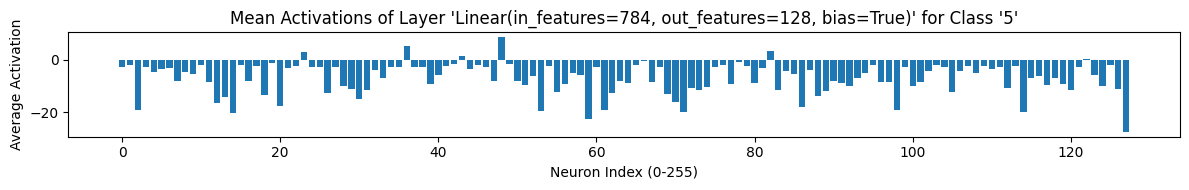

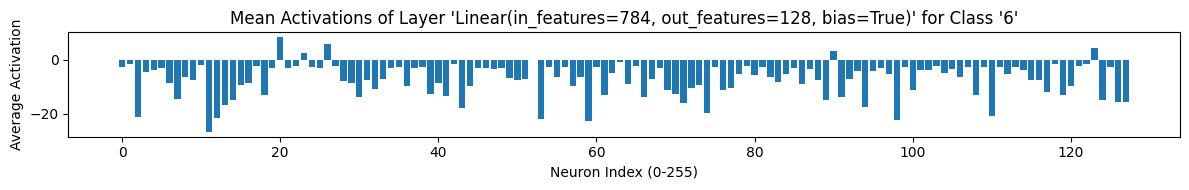

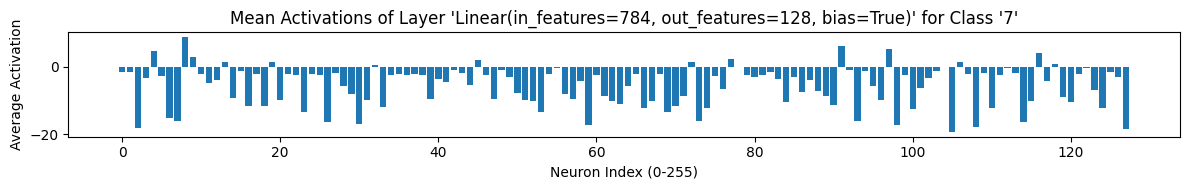

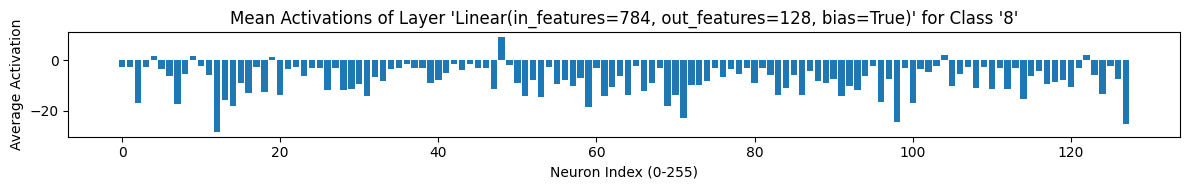

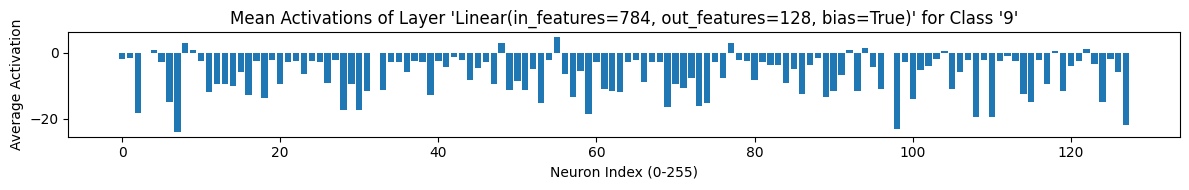

In [43]:
# --- Visualization ---
layers = [model.dim_reduction]#, model.hidden_layers[0], model.hidden_layers[2], model.hidden_layers[4], model.output]
for target_class_to_viz, target_layer_to_viz in itertools.product(range(10), layers):
    # We are inspecting the first linear layer (the one that projects to 256 dims)
    mean_activations = get_mean_activation_map(model, target_layer_to_viz, target_class_to_viz, zip(full_mnist.to(device)[:1000], labels.to(device)[:1000]))
    print(mean_activations.shape)

    if mean_activations is not None:
        plt.figure(figsize=(12, 2))
        plt.title(f"Mean Activations of Layer '{target_layer_to_viz}' for Class '{target_class_to_viz}'")
        plt.bar(range(len(mean_activations)), mean_activations)
        plt.xlabel("Neuron Index (0-255)")
        plt.ylabel("Average Activation")
        plt.tight_layout()
plt.show()

In [65]:
def visualize_activation_space(model, target_layer, data_loader, method='pca'):
    """
    Visualizes the activation space of a layer using dimensionality reduction.

    Args:
        model (nn.Module): The trained neural network.
        target_layer (nn.Module): The layer to inspect.
        data_loader (DataLoader): DataLoader to get a batch of images.
        method (str): 'pca' or 'tsne' for dimensionality reduction.
    """
    model.eval()
    all_activations = []
    all_labels = []

    # --- Step 1: Attach a hook to get activations ---
    def hook_fn(module, input, output):
        # Flatten the batch of activations and store them
        all_activations.append(output.detach().cpu().numpy())

    hook = target_layer.register_forward_hook(hook_fn)

    # --- Step 2: Get a batch of data and pass it through the model ---
    images, labels = next(iter(data_loader))
    with torch.no_grad():
        model(images.flatten(-2, -1).to(device))
        all_labels = labels.cpu().numpy()

    hook.remove()

    # --- Step 3: Reduce dimensionality and plot ---
    activations_np = np.concatenate(all_activations, axis=0).squeeze()

    print(f"Reducing {activations_np.shape[1]}-dimensional activations to 2D using {method.upper()}...")
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")
    reduced_activations = reducer.fit_transform(activations_np)

    # --- Visualization ---
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_activations[:, 0], reduced_activations[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
    plt.title(f"Activation Space of Layer '{target_layer}' ({method.upper()})")
    plt.xlabel(f"{method.upper()} Component 1")
    plt.ylabel(f"{method.upper()} Component 2")
    plt.legend(handles=scatter.legend_elements()[0], labels=range(10), title="Classes")
    plt.show()

Reducing 128-dimensional activations to 2D using TSNE...


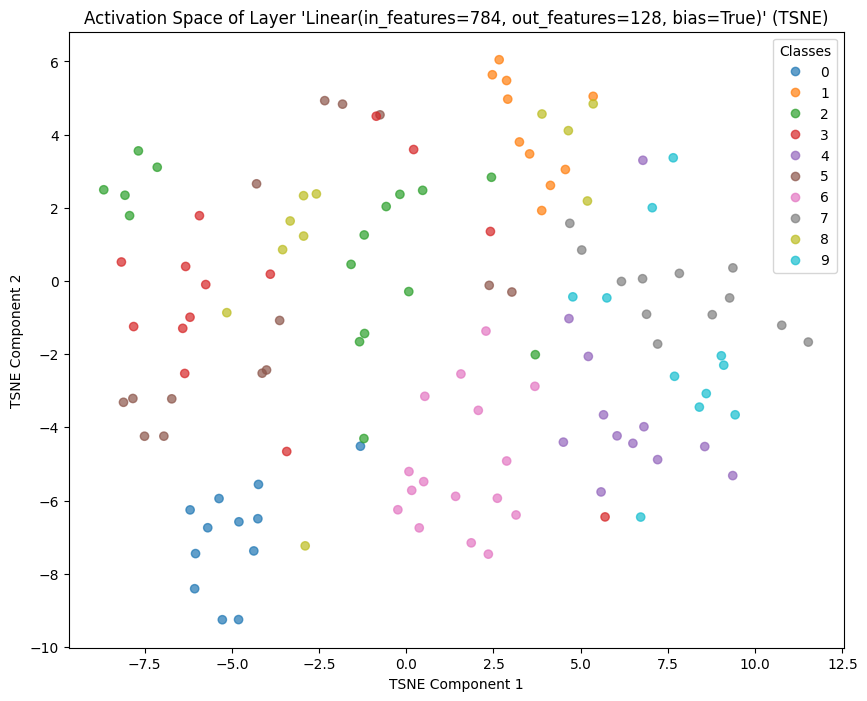

Reducing 128-dimensional activations to 2D using TSNE...


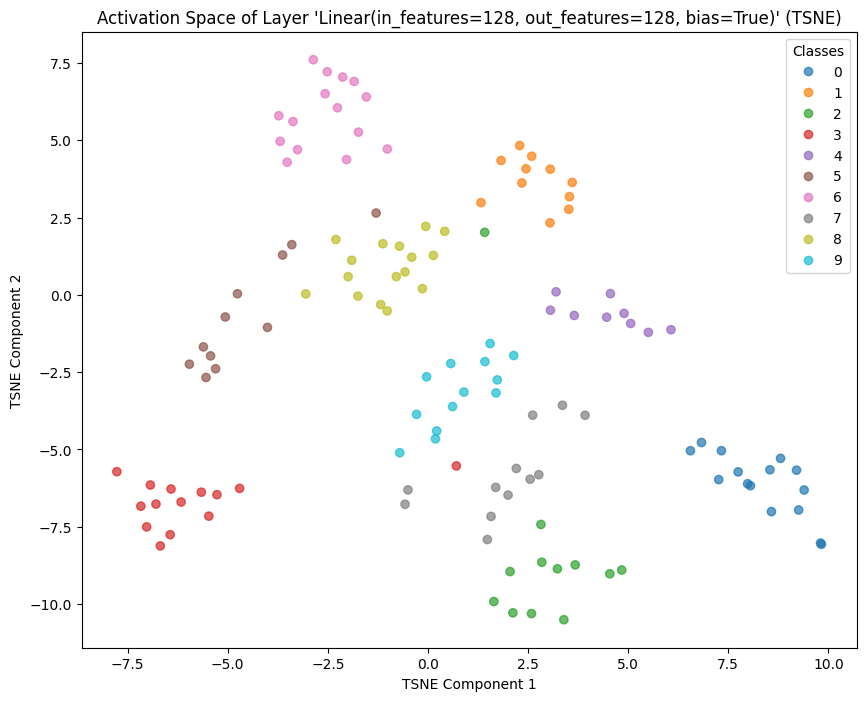

Reducing 128-dimensional activations to 2D using TSNE...


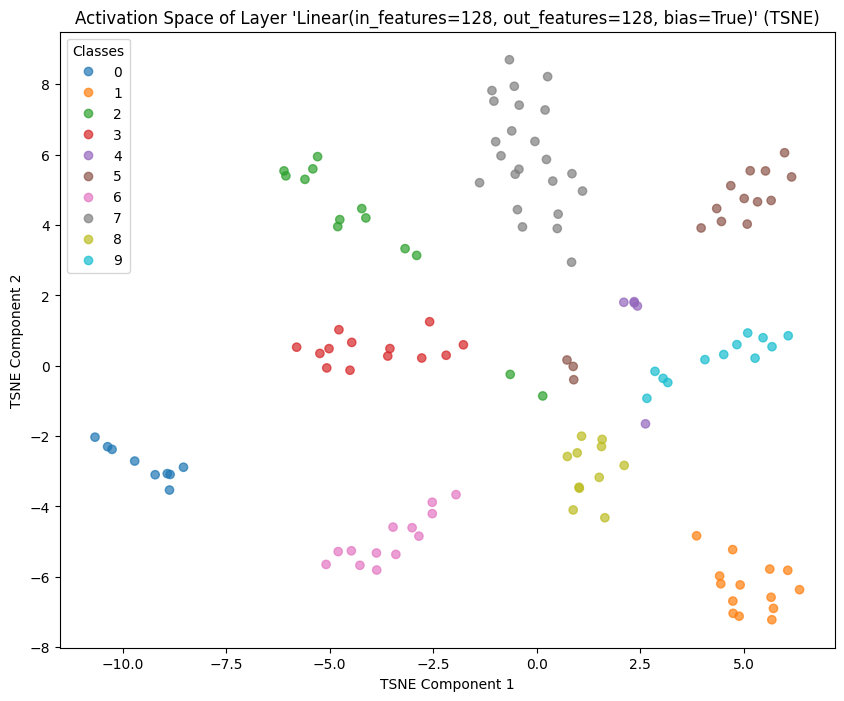

Reducing 128-dimensional activations to 2D using TSNE...


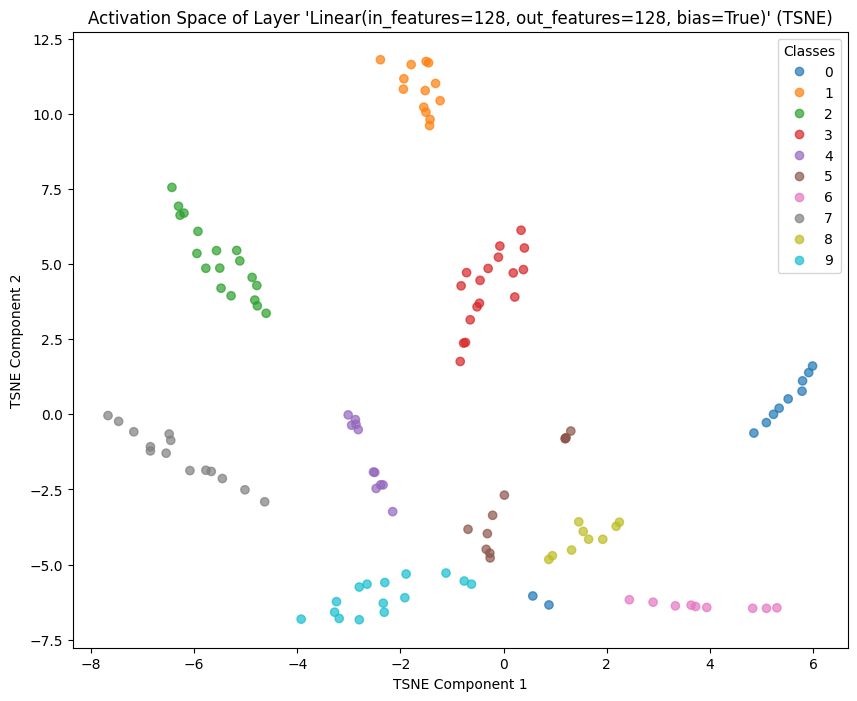

Reducing 10-dimensional activations to 2D using TSNE...


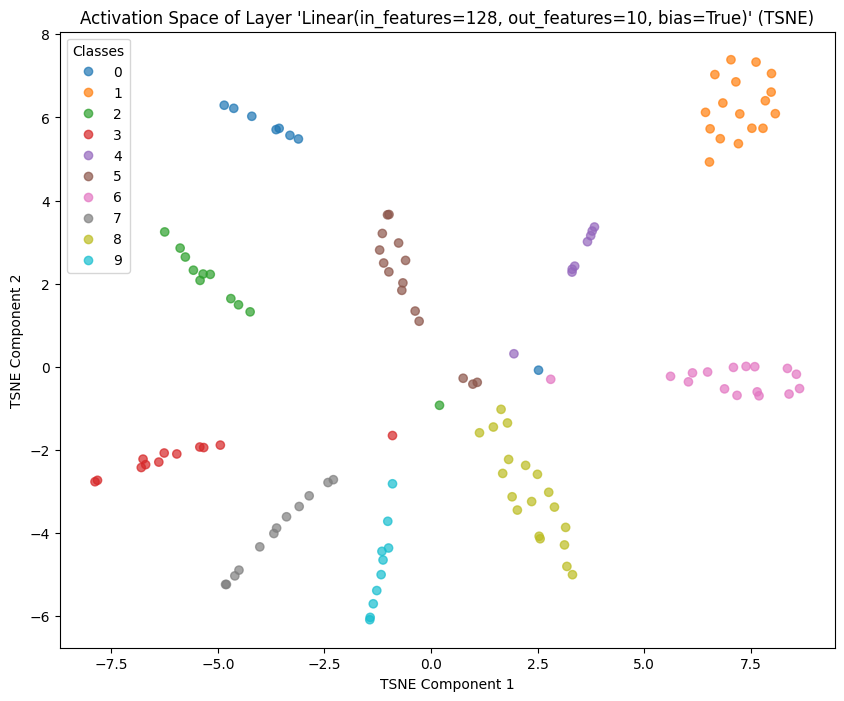

In [67]:
# Visualize the activation space of the first linear layer
for layer in [model.dim_reduction, model.hidden_layers[0], model.hidden_layers[2], model.hidden_layers[4], model.output]:
    visualize_activation_space(model, layer, train_loader, method='tsne')